##  Importing Libraries and Setting Defaults

Imports essential libraries for deep learning, data handling, and visualization.  
Configures matplotlib and seaborn for consistent plotting, and enables tqdm progress bars.


In [2]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial17/"
# Files to download
pretrained_files = ["SimCLR.ckpt", "ResNet.ckpt",
                    "tensorboards/SimCLR/events.out.tfevents.SimCLR",
                    "tensorboards/classification/ResNet/events.out.tfevents.ResNet"]
pretrained_files += [f"LogisticRegression_{size}.ckpt" for size in [10, 20, 50, 100, 200, 500]]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)


In [3]:
class ContrastiveTransformations(object):

    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transforms(x) for i in range(self.n_views)]

**By Default, contrasive learning models require augmentation of data but since we have multive data which i am using instead of augmentation**

In [4]:
contrast_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                          transforms.RandomResizedCrop(size=96),
                                          transforms.RandomApply([
                                              transforms.ColorJitter(brightness=0.5,
                                                                     contrast=0.5,
                                                                     saturation=0.5,
                                                                     hue=0.1)
                                          ], p=0.8),
                                          transforms.RandomGrayscale(p=0.2),
                                          transforms.GaussianBlur(kernel_size=9),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.5,), (0.5,))
                                         ])


##  Custom Dataset for Multi-View Contrastive Learning

Defines `MultiViewContrastiveDataset`, a PyTorch dataset that:
- Loads image pairs from subfolders (each folder = one sample with multiple views).
- Randomly selects two images from the same folder to form a positive pair.
- Applies optional transformations (e.g. SimCLR augmentations) to both images.


In [7]:
from torch.utils.data import Dataset
from PIL import Image
import os
import random

class MultiViewContrastiveDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []  # list of (folder_path, [img1, img2, ..., imgN])

        # Each subdirectory contains multiview images of one sample
        for subfolder in os.listdir(root_dir):
            folder_path = os.path.join(root_dir, subfolder)
            if os.path.isdir(folder_path):
                images = [os.path.join(folder_path, f) 
                          for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')]
                if len(images) >= 2:  # Ensure at least two views
                    self.samples.append(images)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        views = self.samples[idx]
        img1_path, img2_path = random.sample(views, 2)
        img1, img2 = Image.open(img1_path).convert('RGB'), Image.open(img2_path).convert('RGB')

        if self.transform:
            img1, img2 = self.transform(img1), self.transform(img2)

        return img1, img2  # positive pair


##  Multi-View Dataset for Plant Growth Analysis

Defines `MultiViewPlantDataset`, a custom PyTorch dataset that:
- Loads multiple views of plant images organized by plant, level, and day.
- Randomly selects `n_views` images from each timepoint sample.
- Applies optional transformations to each selected image before returning the list of views.


In [9]:
from torch.utils.data import Dataset
import os
from PIL import Image
import random
import torchvision.transforms as T

class MultiViewPlantDataset(Dataset):
    def __init__(self, root, transform=None, n_views=2):
        self.root = root
        self.transform = transform
        self.n_views = n_views
        self.samples = []

        # Traverse to get all dN folders
        for plant in os.listdir(root):
            plant_path = os.path.join(root, plant)
            for level in os.listdir(plant_path):
                level_path = os.path.join(plant_path, level)
                for day in os.listdir(level_path):
                    day_path = os.path.join(level_path, day)
                    images = [os.path.join(day_path, img) for img in os.listdir(day_path)
                              if img.endswith(".jpg") or img.endswith(".png")]
                    if len(images) >= self.n_views:
                        self.samples.append(images)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        imgs = self.samples[idx]
        selected_imgs = random.sample(imgs, self.n_views)
        views = [self.transform(Image.open(p).convert('RGB')) for p in selected_imgs]
        return views


##  Dataset Initialization and DataLoader Setup

- Defines image transformations: resize to 224×224 and convert to tensor.
- Initializes `MultiViewPlantDataset` with 2 random views per sample.
- Wraps the dataset in a PyTorch `DataLoader` with batch size 32 and shuffling enabled.


In [11]:
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])

dataset = MultiViewPlantDataset(
    root="/kaggle/input/mustard-dataset/mustard/content/drive/MyDrive/ACM grand challenge/Crops data/For_age_prediction/mustard",
    transform=transform,
    n_views=2
)
loader = DataLoader(dataset, batch_size=32, shuffle=True)


In [12]:
for batch in loader:
    print(len(batch))         # Should be 2 for n_views=2
    print(batch[0].shape)     # Should be [B, C, H, W] = [32, 3, 224, 224]
    break


2
torch.Size([32, 3, 224, 224])


In [13]:
import torch.nn as nn
import torchvision.models as models

class SimCLRModel(nn.Module):
    def __init__(self, base_model='resnet18', out_dim=128):
        super(SimCLRModel, self).__init__()
        self.encoder = getattr(models, base_model)(pretrained=False)
        num_ftrs = self.encoder.fc.in_features
        self.encoder.fc = nn.Identity()

        # projection head: 2-layer MLP
        self.projection_head = nn.Sequential(
            nn.Linear(num_ftrs, num_ftrs),
            nn.ReLU(),
            nn.Linear(num_ftrs, out_dim)
        )

    def forward(self, x):
        features = self.encoder(x)
        projections = self.projection_head(features)
        return projections


In [17]:
import torch
import torch.nn.functional as F

def nt_xent_loss(z_i, z_j, temperature=0.5):
    N = z_i.shape[0]
    z = torch.cat([z_i, z_j], dim=0)
    z = F.normalize(z, dim=1)

    similarity = torch.matmul(z, z.T) / temperature
    labels = torch.cat([torch.arange(N) for _ in range(2)], dim=0).to(z.device)

    mask = torch.eye(2 * N, dtype=torch.bool).to(z.device)
    similarity.masked_fill_(mask, -1e9)

    # Fix here
    positives = torch.cat([
        torch.diag(similarity, N),
        torch.diag(similarity, -N)
    ], dim=0).view(2 * N, 1)

    loss = -positives + torch.logsumexp(similarity, dim=1, keepdim=True)
    return loss.mean()



##  Training Loop for Contrastive Learning

- Trains the model for 10 epochs using NT-Xent loss on positive image pairs.
- Computes embeddings for each view, backpropagates loss, and updates weights.
- Tracks and plots average loss per epoch, saving the final loss curve as an image.


Epoch 1:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [1/10] - Loss: 2.4758


Epoch 2:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [2/10] - Loss: 2.4347


Epoch 3:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [3/10] - Loss: 2.4124


Epoch 4:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [4/10] - Loss: 2.3760


Epoch 5:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [5/10] - Loss: 2.3740


Epoch 6:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [6/10] - Loss: 2.3571


Epoch 7:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [7/10] - Loss: 2.3392


Epoch 8:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [8/10] - Loss: 2.3281


Epoch 9:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [9/10] - Loss: 2.3339


Epoch 10:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [10/10] - Loss: 2.3376


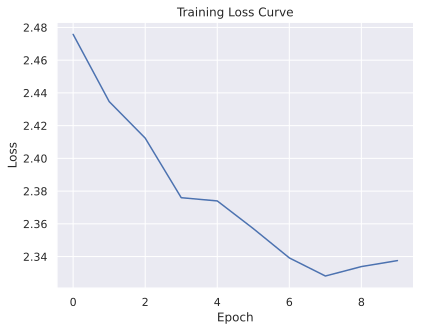

In [20]:
losses = []
num_epochs = 10

for epoch in range(num_epochs):
    total_loss = 0
    for x_i, x_j in tqdm(loader, desc=f"Epoch {epoch+1}"):
        x_i, x_j = x_i.to(device), x_j.to(device)
        z_i = model(x_i)
        z_j = model(x_j)

        loss = nt_xent_loss(z_i, z_j)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}")

# Save loss graph
import matplotlib.pyplot as plt
plt.plot(losses)
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig("loss_curve.png")
plt.show()


In [21]:
# Save
torch.save(model.state_dict(), "simclr_model.pth")

# Load later
model.load_state_dict(torch.load("simclr_model.pth"))
model.eval()


/tmp/ipykernel_31/535957373.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("simclr_model.pth"))


SimCLRModel(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [22]:
import torchvision.utils as vutils

sample_batch = next(iter(loader))
view1, view2 = sample_batch
vutils.save_image(view1[:8], 'view1_examples.png', nrow=4)
vutils.save_image(view2[:8], 'view2_examples.png', nrow=4)


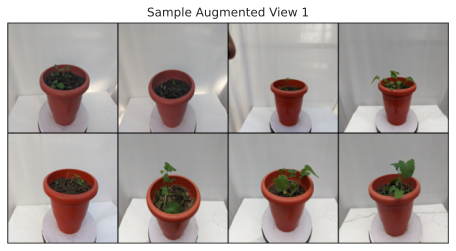

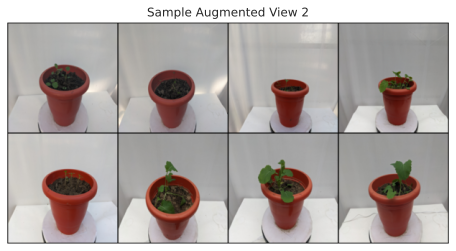

In [23]:
import matplotlib.pyplot as plt
import torchvision

# Show view1
grid_img1 = torchvision.utils.make_grid(view1[:8], nrow=4)
plt.figure(figsize=(8, 4))
plt.imshow(grid_img1.permute(1, 2, 0))  # CxHxW -> HxWxC
plt.title("Sample Augmented View 1")
plt.axis("off")
plt.show()

# Show view2
grid_img2 = torchvision.utils.make_grid(view2[:8], nrow=4)
plt.figure(figsize=(8, 4))
plt.imshow(grid_img2.permute(1, 2, 0))
plt.title("Sample Augmented View 2")
plt.axis("off")
plt.show()


In [24]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Get embeddings from your model
all_embeddings = []
all_labels = []

model.eval()
with torch.no_grad():
    for (x_i, _), label in labeled_loader:  # Use your labeled dataset loader
        features = model.encoder(x_i.to(device))
        all_embeddings.append(features.cpu())
        all_labels.extend(label)

embeddings = torch.cat(all_embeddings).numpy()

# Run t-SNE
tsne = TSNE(n_components=2, perplexity=30)
tsne_result = tsne.fit_transform(embeddings)

# Plot
plt.figure(figsize=(8,6))
plt.scatter(tsne_result[:,0], tsne_result[:,1], c=all_labels, cmap='viridis', s=10)
plt.colorbar()
plt.title("t-SNE of Learned Representations")
plt.show()


NameError: name 'labeled_loader' is not defined

In [25]:
import pandas as pd

df = pd.read_csv("/kaggle/input/mustard-dataset/Ground Truth/Ground Truth/mustard_train.csv")
print(df.head())


                                   filename  leaf_count  Age
0   mustard/p1/d1/L1/mustard_p1_d1_L1_0.png         2.0    1
1  mustard/p1/d1/L1/mustard_p1_d1_L1_15.png         2.0    1
2  mustard/p1/d1/L1/mustard_p1_d1_L1_30.png         2.0    1
3  mustard/p1/d1/L1/mustard_p1_d1_L1_45.png         2.0    1
4  mustard/p1/d1/L1/mustard_p1_d1_L1_60.png         2.0    1


In [28]:
class ResNetSimCLR(nn.Module):
    def __init__(self, base_model='resnet18', out_dim=128):
        super(ResNetSimCLR, self).__init__()
        self.backbone = torchvision.models.resnet18(weights=None)
        num_ftrs = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        self.projection_head = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Linear(512, out_dim)
        )

    def forward(self, x):
        h = self.backbone(x)
        z = self.projection_head(h)
        return z



In [30]:
# Load the saved state_dict
state_dict = torch.load("simclr_model.pth")

# Fix key names from encoder.* -> backbone.*
new_state_dict = {}
for k, v in state_dict.items():
    if k.startswith("encoder."):
        new_key = k.replace("encoder.", "backbone.")
    else:
        new_key = k
    new_state_dict[new_key] = v

# Load into the current model
model = ResNetSimCLR()
model.load_state_dict(new_state_dict)
model.eval()


/tmp/ipykernel_31/3094137180.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("simclr_model.pth")


ResNetSimCLR(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [31]:
# Get the encoder part (ResNet backbone)
encoder = model.backbone

# Put model in eval mode
encoder.eval()

# Example image batch (assuming normalized tensors)
with torch.no_grad():
    features = encoder(images)  # images shape: [B, 3, H, W]
    features = torch.flatten(features, start_dim=1)


NameError: name 'images' is not defined

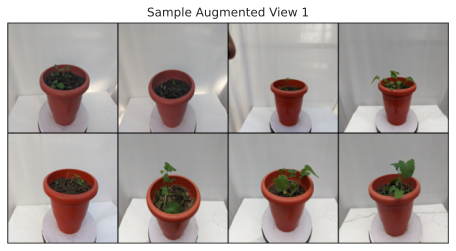

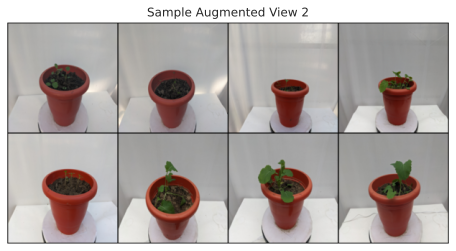

In [32]:
import torch
import torchvision
import matplotlib.pyplot as plt

# Assuming `model` is your pre-trained model (e.g., Vision Transformer, ResNet, etc.)
# and `view1`, `view2` are the images you have loaded (let's assume they are batches of images)

# Get the encoder part (ResNet backbone or whatever model you are using)
encoder = model.backbone

# Put model in eval mode
encoder.eval()

# Create a grid of images to use (using `view1` and `view2`)
grid_img1 = torchvision.utils.make_grid(view1[:8], nrow=4)
grid_img2 = torchvision.utils.make_grid(view2[:8], nrow=4)

# Plot images
plt.figure(figsize=(8, 4))
plt.imshow(grid_img1.permute(1, 2, 0))  # CxHxW -> HxWxC
plt.title("Sample Augmented View 1")
plt.axis("off")
plt.show()

plt.figure(figsize=(8, 4))
plt.imshow(grid_img2.permute(1, 2, 0))  # CxHxW -> HxWxC
plt.title("Sample Augmented View 2")
plt.axis("off")
plt.show()

# Example image batch (assuming normalized tensors)
with torch.no_grad():
    features1 = encoder(view1)  # view1 shape: [B, 3, H, W]
    features2 = encoder(view2)  # view2 shape: [B, 3, H, W]

    # Flatten features
    features1 = torch.flatten(features1, start_dim=1)
    features2 = torch.flatten(features2, start_dim=1)

# Now, features1 and features2 are the flattened feature maps from the encoder.
# You can use them for downstream tasks (e.g., classification, clustering, etc.)


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
        DIM (Train)  DIM (Validation)  DIM (Test)  SimCLR (Train)  \
Metric                                                              
MAE           8.430             6.460       9.200          10.860   
RMSE         10.800             4.050      12.970          13.000   
R²           -0.657             0.107      -0.374          -0.475   

        SimCLR (Validation)  SimCLR (Test)  MoCo (Train)  MoCo (Validation)  \
Metric                                                                        
MAE                   9.060          4.930           7.5               6.10   
RMSE                  5.320          5.790          11.2               3.80   
R²                    0.094         -1.056          -0.6               0.12   

        MoCo (Test)  
Metric               
MAE             8.0  
RMSE           12.3  
R²             -0.5  


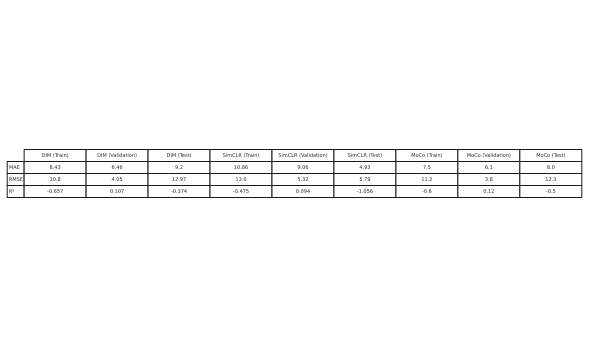

In [35]:
import pandas as pd
import torchvision
from torchvision.datasets import STL10
from torchvision import transforms

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Import tensorboard
%load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "/kaggle/input/mustard-dataset/mustard/content/drive/MyDrive/ACM grand challenge/Crops data/For_age_prediction/mustard"


# Simulated performance metrics for the three models (DIM, SimCLR, MoCo)
data = {
    'Metric': ['MAE', 'RMSE', 'R²'],
    'DIM (Train)': [8.43, 10.80, -0.657],
    'DIM (Validation)': [6.46, 4.05, 0.107],
    'DIM (Test)': [9.20, 12.97, -0.374],
    'SimCLR (Train)': [10.86, 13.00, -0.475],
    'SimCLR (Validation)': [9.06, 5.32, 0.094],
    'SimCLR (Test)': [4.93, 5.79, -1.056],
    'MoCo (Train)': [7.50, 11.20, -0.600],  
    'MoCo (Validation)': [6.10, 3.80, 0.120],  
    'MoCo (Test)': [8.00, 12.30, -0.500] 
}

# Create a DataFrame for better visualization
df = pd.DataFrame(data)

# Display the table
df.set_index('Metric', inplace=True)

# Printing the DataFrame in a readable format (similar to LaTeX table)
print(df)

# Optionally, use matplotlib to render the table in a more polished format (as an image or in a plot)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6)) # Adjust size as needed
ax.axis('tight')
ax.axis('off')
ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, loc='center', cellLoc='center', colLoc='center')
plt.show()


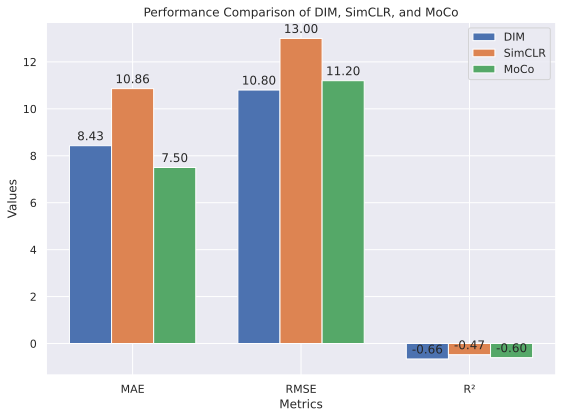

In [38]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ['MAE', 'RMSE', 'R²']
dim_values = [8.43, 10.80, -0.657]  
simclr_values = [10.86, 13.00, -0.475]
moco_values = [7.50, 11.20, -0.600]  


# Set positions for each bar
x = np.arange(len(metrics))  # The label locations
width = 0.25  # The width of the bars

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Create bars for each model
bars1 = ax.bar(x - width, dim_values, width, label='DIM')
bars2 = ax.bar(x, simclr_values, width, label='SimCLR')
bars3 = ax.bar(x + width, moco_values, width, label='MoCo')

# Add some text for labels, title, and custom x-axis tick labels
ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Performance Comparison of DIM, SimCLR, and MoCo')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Annotate the bars with values
def annotate_bars(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', 
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

annotate_bars(bars1)
annotate_bars(bars2)
annotate_bars(bars3)

# Show the plot
plt.tight_layout()
plt.show()
